In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import Point
import geopandas as gpd

##### Read households and add location point

In [6]:
city_name = 'chelyabinsk'
data_dir = '../data/initial_' + city_name + '/'
city_districts_file = data_dir + 'districts.geojson'

households = pd.read_csv(data_dir + 'households.txt', sep = '\t')

def generate_point_from_coords(row):
    return Point([row['longitude'], row['latitude']])

households['location'] = households.apply(generate_point_from_coords, axis=1)

##### Read MO from city and get polygons of them

In [8]:
municipal_districts = gpd.read_file(city_districts_file)
municipal_districts = municipal_districts.rename(columns={'name': 'mo_name'})
municipal_districts = municipal_districts.sort_values(by = ['mo_name'])
municipal_districts

,osm_id,boundary,admin_level,parents,mo_name,local_name,name_en,geometry
6,-1579610,administrative,9,"-398407,-77687,-1113276,-60189",Kurchatovskiy rayon,Курчатовский район,Kurchatovskiy rayon,"POLYGON ((61.25546 55.17940, 61.25550 55.17939..."
0,-1581744,administrative,9,"-398407,-77687,-1113276,-60189",Leninskiy rayon,Ленинский район,Leninskiy rayon,"POLYGON ((61.40694 55.10744, 61.40857 55.10690..."
2,-1581689,administrative,8,"-398407,-77687,-1113276,-60189",Sovetskiy rayon,Советский район,Sovetskiy rayon,"POLYGON ((61.14360 55.05351, 61.14366 55.05340..."
5,-1579611,administrative,9,"-398407,-77687,-1113276,-60189",Калининский район,Калининский район,None,"POLYGON ((61.27973 55.17644, 61.27974 55.17540..."
3,-1581688,administrative,9,"-398407,-77687,-1113276,-60189",Металлургический район,Металлургический район,None,"POLYGON ((61.34674 55.29330, 61.34678 55.29326..."
1,-1581743,administrative,9,"-398407,-77687,-1113276,-60189",Тракторозаводский район,Тракторозаводский район,None,"POLYGON ((61.42049 55.17756, 61.42125 55.17632..."
4,-1579833,administrative,9,"-398407,-77687,-1113276,-60189",Центральный район,Центральный район,None,"POLYGON ((61.24353 55.14247, 61.24375 55.14185..."


In [10]:
from tqdm import tqdm
tqdm.pandas()

def assign_mo_id(row):
    for district, geom in zip(municipal_districts['mo_name'], municipal_districts['geometry']):
        if geom.contains(row['location']):
            return str(district)
        
        
# uncomment next line if you want to create additional column with municipal district id of each household in data - this will take a while       
households['mo_name'] = households.progress_apply(assign_mo_id, axis=1)

  0%|          | 0/1189525 [00:00<?, ?it/s]

100%|██████████| 1189525/1189525 [03:21<00:00, 5900.31it/s] 


In [11]:
households.to_csv(data_dir + 'households_with_mo_name_' + city_name + '.txt', sep = '\t')

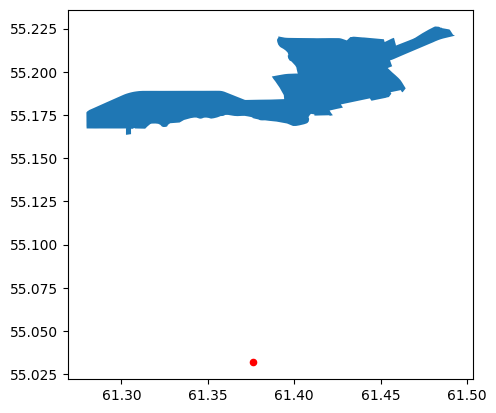

In [12]:
household = households.iloc[10]
household

district = municipal_districts.iloc[3]
mo = gpd.GeoDataFrame(columns=['mo_name', 'geometry'])
mo.loc[0] = district
mo
mo.plot()
plt.scatter(household['longitude'], household['latitude'], s=20, color='red')

In [22]:
households = pd.read_csv(data_dir + 'households_with_mo_name_' + city_name + '.txt', sep='\t', index_col=0)
### SAMPLE FRACTION 
fraction = 0.01
### 

sampled_households_df = pd.DataFrame([])
for mo_id in municipal_districts['mo_name']:
    mo_df = households[households['mo_name'] == mo_id]
    mo_df = mo_df.sample(frac=fraction) # take 5 percents of all apartaments in each municipal district
    sampled_households_df = pd.concat([sampled_households_df, mo_df])
sampled_households_df.to_csv(data_dir + 'households_sampled.txt', sep = '\t')

##### Remove people from deleted apartaments

In [23]:
sampled_households_df

,sp_id,hh_size,latitude,longitude,location,mo_name
921246,365668,3,55.193647,61.285066,POINT (61.285065687 55.193646942),Kurchatovskiy rayon
1026646,407599,6,55.212007,61.288892,POINT (61.288891536 55.212006656),Kurchatovskiy rayon
842480,334394,4,55.188509,61.294575,POINT (61.294574968 55.188508942),Kurchatovskiy rayon
986324,391546,2,55.199700,61.340258,POINT (61.340258375 55.199700304),Kurchatovskiy rayon
902205,358084,4,55.192475,61.292760,POINT (61.292760266 55.192474918),Kurchatovskiy rayon
...,...,...,...,...,...,...
353692,139986,2,55.158330,61.380040,POINT (61.38004045 55.1583295),Центральный район
443258,175533,4,55.168652,61.424491,POINT (61.424490572 55.168651854),Центральный район
500642,198370,7,55.171994,61.368373,POINT (61.368373229 55.171994296),Центральный район
450436,178384,2,55.169270,61.276315,POINT (61.27631485 55.169269617),Центральный район


In [25]:
set_of_households = set()
for sp_id in sampled_households_df['sp_id']:
    set_of_households.add(sp_id)

print("Number of households:", len(set_of_households))
people_df = pd.read_csv(data_dir + 'people.txt', sep = '\t', index_col=0) 

Number of households: 11736


In [26]:
people_sampled = people_df[people_df['sp_hh_id'].isin(set_of_households)]
people_sampled.to_csv(data_dir + 'people_sampled.txt', sep = '\t')

In [27]:
import os
import json

set_of_people = set(people_sampled.index.unique())

dict_school_id = json.load(open(os.path.expanduser(data_dir + 'schools.json')))

dict_school_id_sampled = {}
for school in dict_school_id:
    current_list_of_students = []
    children_in_current_school = dict_school_id[school]
    for child in children_in_current_school:
        if child in set_of_people:
            current_list_of_students.append(child)
    dict_school_id_sampled[school] = current_list_of_students
    # if school == '425':
    #     print(current_list_of_students)
            
dict_school_id_sampled 
with open(data_dir + 'schools_sampled.json', 'w') as fp:
    json.dump(dict_school_id_sampled, fp)     
    

In [28]:
dict_school_id

{'36': [0,
  219,
  851,
  948,
  1107,
  1229,
  1595,
  1599,
  1997,
  2012,
  2278,
  2564,
  2574,
  2939,
  3008,
  3018,
  3110,
  3209,
  3256,
  3647,
  3661,
  3774,
  4193,
  4564,
  4603,
  4766,
  4850,
  5288,
  5462,
  5616,
  5742,
  6040,
  6100,
  6101,
  6264,
  6498,
  6613,
  6618,
  6681,
  6764,
  7091,
  7452,
  7500,
  7519,
  7556,
  7686,
  7773,
  8100,
  8625,
  8740,
  8860,
  8938,
  9025,
  9234,
  9410,
  11064,
  11114,
  12491,
  12550,
  12685,
  13098,
  13471,
  13961,
  14323,
  14777,
  15440,
  15496,
  16532,
  16984,
  17279,
  18108,
  18422,
  18440,
  18442,
  18598,
  19126,
  19341,
  19716,
  20158,
  20368,
  20372,
  21235,
  21948,
  22105,
  23734,
  24044,
  24285,
  24446,
  24688,
  25042,
  25333,
  25411,
  25415,
  26032,
  26055,
  26654,
  27484,
  28166,
  28216,
  28337,
  28635,
  28827,
  29207,
  29405,
  29461,
  29762,
  30155,
  30581,
  31072,
  31486,
  31706,
  32448,
  32944,
  33223,
  33546,
  34332,
  35165,
  